# This notebook will show how to use the ROSE framework to run a custom Active Learning strategy

In [ ]:
import os
import sys

from rose.learner import Learner
from rose.metrics import MODEL_ACCURACY

from radical.asyncflow import WorkflowEngine
from rhapsody.backends import RadicalExecutionBackend

## Custom Active Learning strategy:
In addition to the predefined workflows we saw in the `examples/basic/run_me.py`, the Active Learner API allows you to design custom active learning strategies tailored to your specific needs. This will allow you to define a flexible and iterative learning loop. For example, you could create a strategy that dynamically adjusts its behavior based on intermediate results, runs tasks in parallel, or incorporates additional utility tasks such as data cleaning or logging.

The following example demonstrates how to create a hybrid workflow that alternates between parallel simulation tasks and training and active learning tasks and incorporates a custom stopping condition based on model performance:

In [ ]:
engine = await RadicalExecutionBackend({'resource': 'local.localhost'})
asyncflow = await WorkflowEngine.create(engine)
learner = Learner(asyncflow)

Resource Engine started successfully



In [ ]:
code_path = f'{sys.executable} {os.getcwd()}'

# Define and register the simulation task
@custom_acl.simulation_task
async def simulation(*args):
    f'{code_path}/simulation.py'

# Define and register the training task
@custom_acl.training_task
async def training(*args):
    f'{code_path}/training.py'

# Define and register the active learning task
@custom_acl.active_learn_task
async def active_learn(*args):
    f'{code_path}/active_learn.py'

# Defining the stop criterion with a metric (MSE in this case)
@custom_acl.as_stop_criterion(metric_name=MODEL_ACCURACY, threshold=0.99)
async def check_accuracy(*args):
    f'{code_path}/check_accuracy.py'

### Define your custom strategy and run it:
In this custom active-learn `start` method, we will submit 3 simulation tasks in parallel and let the training task handle their output. In this example, we are targeting the Accuracy metric of the trained model, and we will stop if we trach an accuracy of 99%

In [ ]:
async def start():
    # 10 iterations of active learning
    for acl_iter in range(10):
        print(f'Starting Iteration-{acl_iter}')
        simulations = []
        for i in range(3):
            # run 3 simulations in parallel
            simulations.append(simulation())

        # wait for all simulation tasks to finish
        await asyncio.gather(*simulations)
        
        # Now run training and active_learn
        train = training(*simulations)
        active = active_learn(simulations, train)

        should_stop, metric_val = await check_accuracy(active)
        # check for the threshold to stop if accuracy is >= 99%
        if should_stop:
            print(f'Accuracy ({metric_val}) met the threshold, breaking...')
            break

# invoke the custom/user-defined start() method
await start()

Registered task 'simulation' and id of 000000 with dependencies: []
Registered task 'simulation' and id of 000001 with dependencies: []
Registered task 'simulation' and id of 000002 with dependencies: []
Registered task 'training' and id of 000003 with dependencies: ['simulation', 'simulation', 'simulation']
Registered task 'active_learn' and id of 000004 with dependencies: ['training']
Registered task 'check_accuracy' and id of 000005 with dependencies: ['active_learn']
Registered task 'simulation' and id of 000006 with dependencies: []
Registered task 'simulation' and id of 000007 with dependencies: []
Registered task 'simulation' and id of 000008 with dependencies: []
Registered task 'training' and id of 000009 with dependencies: ['simulation', 'simulation', 'simulation']
Registered task 'active_learn' and id of 000010 with dependencies: ['training']
Registered task 'check_accuracy' and id of 000011 with dependencies: ['active_learn']
Registered task 'simulation' and id of 000012 wi

Let's make sure to shutdown the resources.

In [ ]:
await learner.shutdown()

Shutdown is triggered, terminating the resources gracefully


### Plot the output:
Now, let's visualize the output of our custom Active learning strategy across N iterations.

Text(0.5, 1.0, 'ACC Values for Machine Learning Model')

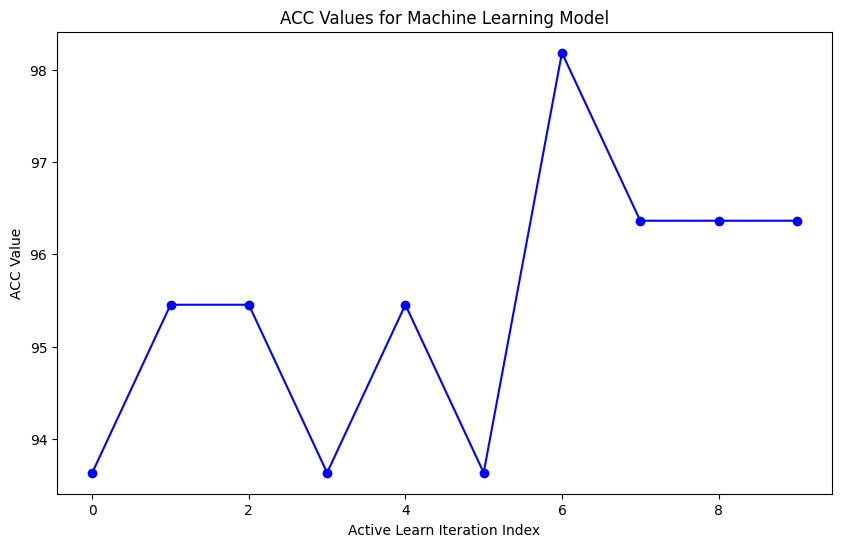

In [ ]:
import matplotlib.pyplot as plt
# Convert string values to floats
mse_values = custom_acl.get_metric_results()
mse_values = [float(acc.strip()) * 100 for acc in mse_values]

# Plot the MSE values
plt.figure(figsize=(10, 6))
plt.plot(mse_values, marker='o', color='b', linestyle='-', markersize=6)

# Add labels and title
plt.xlabel('Active Learn Iteration Index')
plt.ylabel('ACC Value')
plt.title('ACC Values for Machine Learning Model')